In [96]:
import brian2 as b2
from brian2 import NeuronGroup, Synapses, PoissonInput, PoissonGroup, network_operation
from brian2.monitors import StateMonitor, SpikeMonitor, PopulationRateMonitor
from random import sample
import numpy.random as rnd
from neurodynex3.tools import plot_tools
import numpy
import matplotlib.pyplot as plt
from math import floor
import time

b2.defaultclock.dt = 0.10 * b2.ms

In [97]:
import pickle

with open('spike_recorded_test2.pickle', 'rb') as handle:
    data = pickle.load(handle)

In [98]:
data.keys()

dict_keys(['index', 'sp_time'])

In [99]:
spikes_t = data['sp_time']*b2.second

In [100]:
spikes_i = data['index']


In [101]:
num_neuron = len(set(spikes_i))

In [102]:
b2.start_scope()

In [103]:
#neuron 의 갯수를 설정하는것에 대해서 좀 더 일괄적인 접근이 필요하다. 

SGG = b2.SpikeGeneratorGroup(num_neuron+1, spikes_i, spikes_t)

In [104]:
#이렇게 run 을 해서 spike 들 생성해주어야 한다. 

M = b2.SpikeMonitor(SGG)


#b2.run(1*b2.second)

In [105]:
time_stamp = M.t/b2.second

In [106]:
time_stamp[:10]

array([], dtype=float64)

In [107]:
M.i[:]

array([], dtype=int32)

In [108]:
list[M.i]

list[<spikemonitor_1.i: array([], dtype=int32)>]

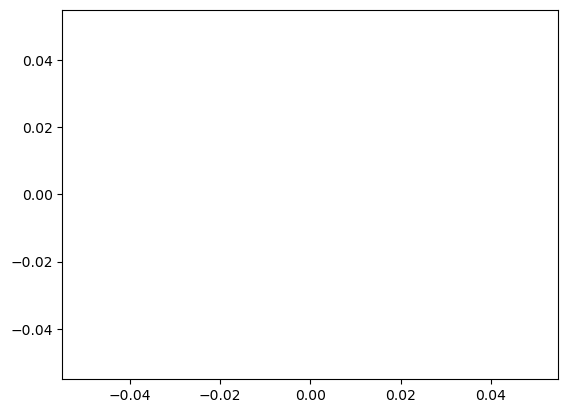

In [109]:
plt.plot(M.t/b2.second, M.i[:], '.k')



In [110]:
# b2.start_scope()

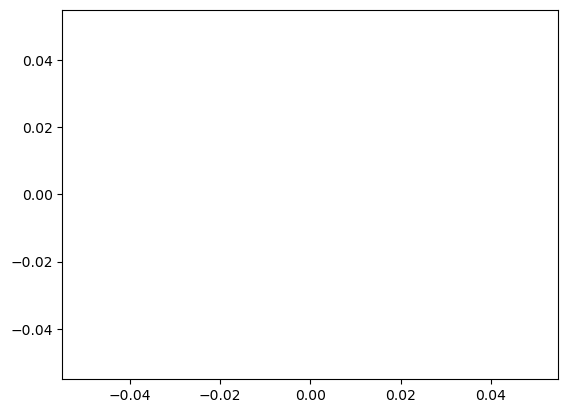

In [111]:
plt.plot(M.t/b2.second, '.k')


In [112]:
N_Excit=384
N_Inhib=96
weight_scaling_factor=5.33
t_stimulus_start=100 * b2.ms 
t_stimulus_duration=9999 * b2.ms
coherence_level=0.
stimulus_update_interval=30 * b2.ms
mu0_mean_stimulus_Hz=250.
stimulus_std_Hz=20.
N_extern=1000
firing_rate_extern=9.8 * b2.Hz
w_pos=10000.90
f_Subpop_size=0.25  # .15 in publication [1]
max_sim_time=1000. * b2.ms 
stop_condition_rate=None
monitored_subset_size=512 
E_leak_excit = -70.0 * b2.mV


In [113]:
N_Excit=341 
N_Inhib=85

In [114]:
print("simulating {} neurons. Start: {}".format(N_Excit + N_Inhib, time.ctime()))
t_stimulus_end = t_stimulus_start + t_stimulus_duration

N_Group_A = int(N_Excit * f_Subpop_size)  # size of the excitatory subpopulation sensitive to stimulus A
N_Group_B = N_Group_A  # size of the excitatory subpopulation sensitive to stimulus B
N_Group_Z = N_Excit - N_Group_A - N_Group_B  # (1-2f)Ne excitatory neurons do not respond to either stimulus.

Cm_excit = 0.5 * b2.nF  # membrane capacitance of excitatory neurons
G_leak_excit = 25.0 * b2.nS  # leak conductance
E_leak_excit = -70.0 * b2.mV  # reversal potential
v_spike_thr_excit = -10.0 * b2.mV  # spike condition
v_reset_excit = -60.0 * b2.mV  # reset voltage after spike
t_abs_refract_excit = 2. * b2.ms  # absolute refractory period

# specify the inhibitory interneuron11s:
# N_Inhib = 200
Cm_inhib = 0.2 * b2.nF
G_leak_inhib = 20.0 * b2.nS
E_leak_inhib = -70.0 * b2.mV
v_spike_thr_inhib = -50.0 * b2.mV
v_reset_inhib = -60.0 * b2.mV
t_abs_refract_inhib = 1.0 * b2.ms

# specify the AMPA synapses
E_AMPA = 0.0 * b2.mV
tau_AMPA = 2.5 * b2.ms

# specify the GABA synapses
E_GABA = -70.0 * b2.mV
tau_GABA = 5.0 * b2.ms

# specify the NMDA synapses
E_NMDA = 0.0 * b2.mV
tau_NMDA_s = 100.0 * b2.ms
tau_NMDA_x = 2. * b2.ms
alpha_NMDA = 0.5 * b2.kHz

# projections from the external population
g_AMPA_extern2inhib = 1.62 * b2.nS
g_AMPA_extern2excit = 2.1 * b2.nS

# projectsions from the inhibitory populations
g_GABA_inhib2inhib = weight_scaling_factor * 1.25 * b2.nS
g_GABA_inhib2excit = weight_scaling_factor * 1.60 * b2.nS

# projections from the excitatory population
g_AMPA_excit2excit = weight_scaling_factor * 0.012 * b2.nS
g_AMPA_excit2inhib = weight_scaling_factor * 0.015 * b2.nS
g_NMDA_excit2excit = weight_scaling_factor * 0.040 * b2.nS
g_NMDA_excit2inhib = weight_scaling_factor * 0.045 * b2.nS  # stronger projection to inhib.

# weights and "adjusted" weights.
w_neg = 1. - f_Subpop_size * (w_pos - 1.) / (1. - f_Subpop_size)
# We use the same postsyn AMPA and NMDA conductances. Adjust the weights coming from different sources:
w_ext2inhib = g_AMPA_extern2inhib / g_AMPA_excit2inhib
w_ext2excit = g_AMPA_extern2excit / g_AMPA_excit2excit
# other weights are 1
print("w_neg={}, w_ext2inhib={}, w_ext2excit={}".format(w_neg, w_ext2inhib, w_ext2excit))

# Define the inhibitory popㅁulation
# dynamics:

simulating 426 neurons. Start: Thu Oct 20 15:01:52 2022
w_neg=-3332.2999999999997, w_ext2inhib=20.262664165103192, w_ext2excit=32.833020637898684


In [115]:
excit_lif_dynamics = """
        s_NMDA_total : 1  # the post synaptic sum of s. compare with s_NMDA_presyn
        dv/dt = (
        - G_leak_excit * (v-E_leak_excit)
        - g_AMPA_excit2excit * s_AMPA * (v-E_AMPA)
        - g_GABA_inhib2excit * s_GABA * (v-E_GABA)
        - g_NMDA_excit2excit * s_NMDA_total * (v-E_NMDA)/(1.0+1.0*exp(-0.062*v/volt)/3.57)
        )/Cm_excit : volt (unless refractory)
        ds_AMPA/dt = -s_AMPA/tau_AMPA : 1
        ds_GABA/dt = -s_GABA/tau_GABA : 1
        ds_NMDA/dt = -s_NMDA/tau_NMDA_s + alpha_NMDA * x * (1-s_NMDA) : 1
        dx/dt = -x/tau_NMDA_x : 1
    """

In [116]:
excit_pop_A = NeuronGroup(1, model=excit_lif_dynamics,
                              threshold="v>v_spike_thr_excit", reset="v=v_reset_excit",
                              refractory=t_abs_refract_excit, method="rk2")

In [117]:
excit_pop_A.v = rnd.uniform(E_leak_excit / b2.mV, high=E_leak_excit / b2.mV + 5., size=excit_pop_A.N) * b2.mV


In [118]:
excit_pop_A.v

<neurongroup_3.v: array([-68.95960848]) * mvolt>

In [119]:
syn_AMPA_A2A = Synapses(SGG, target=excit_pop_A, on_pre="s_AMPA += w_pos", delay=0.5 * b2.ms)
syn_AMPA_A2A.connect(p=1.)

In [120]:
state_M = StateMonitor(excit_pop_A, 'v', record=True)


In [121]:
#b2.start_scope()

In [122]:
b2.run(2*b2.second)


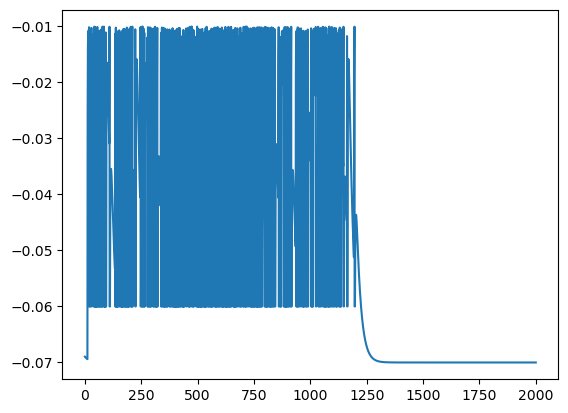

In [123]:
plt.plot(state_M.t/b2.ms, state_M.v[0], label='Neuron 0')
